In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from scipy.stats import norm
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.utils import make_grid as make_image_grid
from tqdm import trange


torch.manual_seed(2017)  # reproducibility
sns.set_style("dark")

# Select device (MPS for Apple Silicon, CUDA for NVIDIA, else CPU)
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)


# Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=500, input_dim=512):
        super(VAE, self).__init__()
        self.fc_e = nn.Linear(input_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_d1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_d2 = nn.Linear(hidden_dim, input_dim)
        self.input_dim = input_dim

    def encoder(self, x_in):
        x = F.relu(self.fc_e(x_in.view(-1, self.input_dim)))
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def decoder(self, z):
        z = F.relu(self.fc_d1(z))
        x_out = torch.sigmoid(self.fc_d2(z))
        # Return as (batch, input_dim) so that it matches x_in
        return x_out

    def sample_normal(self, mean, logvar):
        sd = torch.exp(logvar * 0.5)
        e = torch.randn(sd.size(), device=device)
        z = e.mul(sd).add_(mean)
        return z

    def forward(self, x_in):
        z_mean, z_logvar = self.encoder(x_in)
        z = self.sample_normal(z_mean, z_logvar)
        x_out = self.decoder(z)
        return x_out, z_mean, z_logvar


# Loss function
def criterion(x_out, x_in, z_mu, z_logvar):
    # Use reduction='sum' to sum over all elements
    bce_loss = F.binary_cross_entropy(x_out, x_in, reduction="sum")
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu**2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0)  # normalize by batch size
    return loss


# MarkovChainRandomSequenceDataset
class MarkovChainRandomSequenceDataset(Dataset):
    def __init__(
        self,
        dataset_size=100,
        sequence_length=512,
        full_vocab_size=100,
        nominal_vocab_size=90,
        nominal_rate=0.99,
    ):
        """
        Initializes the dataset with random sequences using a Markov chain model.
        Each sequence is a vector of length sequence_length.
        """
        self.data = []
        self.labels = []
        self.dataset_size = dataset_size
        self.sequence_length = sequence_length
        self.full_vocab_size = full_vocab_size
        self.nominal_vocab_size = nominal_vocab_size
        self.nominal_rate = nominal_rate

        # Generate sequences for both modes
        nominal_sequences = int(self.dataset_size * self.nominal_rate)
        anominal_sequences = self.dataset_size - nominal_sequences

        # Transition matrices
        self.P_nominal = self.create_nominal_transition_matrix()
        self.P_anominal = self.create_anominal_transition_matrix()

        # Generate mode 1 sequences (first mode)
        for _ in range(nominal_sequences):
            sequence = self._generate_markov_chain_sequence(mode="nominal")
            self.data.append(sequence)
            self.labels.append(0)  # Label 0 for mode 1

        # Generate mode 2 sequences (second mode)
        for _ in range(anominal_sequences):
            sequence = self._generate_markov_chain_sequence(mode="anominal")
            self.data.append(sequence)
            self.labels.append(1)  # Label 1 for mode 2

        pass

    def create_nominal_transition_matrix(self):
        P = np.zeros(self.full_vocab_size, dtype=float)
        P[: self.nominal_vocab_size] = 1 / self.nominal_vocab_size
        return P

    def create_anominal_transition_matrix(self):
        P = np.ones(self.full_vocab_size, dtype=float) / self.full_vocab_size
        return P

    def _generate_markov_chain_sequence(self, mode):
        # Select the transition matrix based on the mode
        transition_matrix = self.P_nominal if mode == "nominal" else self.P_anominal

        # Start with a random token
        if mode == "nominal":
            current_state = np.random.choice(self.nominal_vocab_size)
        else:
            current_state = np.random.choice(self.full_vocab_size)

        normalized_data = current_state / self.full_vocab_size
        sequence = [normalized_data]

        # Generate the rest of the sequence using the transition probabilities
        for _ in range(self.sequence_length - 1):
            current_state = np.random.choice(self.full_vocab_size, p=transition_matrix)
            normalized_data = current_state / self.full_vocab_size
            sequence.append(normalized_data)
        return sequence

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return sequence and label as tensors.
        # Here, the sequence is a vector of length sequence_length.
        sequence = self.data[idx]
        label = self.labels[idx]
        return torch.tensor(sequence).float(), torch.tensor(label).float()


# instantiate model and optimizer
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters())

train_dataset = MarkovChainRandomSequenceDataset(
    dataset_size=1000,
    sequence_length=512,
    full_vocab_size=100,
    nominal_vocab_size=90,
    nominal_rate=1,
)
test_dataset = MarkovChainRandomSequenceDataset(
    dataset_size=1000,
    sequence_length=512,
    full_vocab_size=100,
    nominal_vocab_size=90,
    nominal_rate=0.9,
)
trainloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


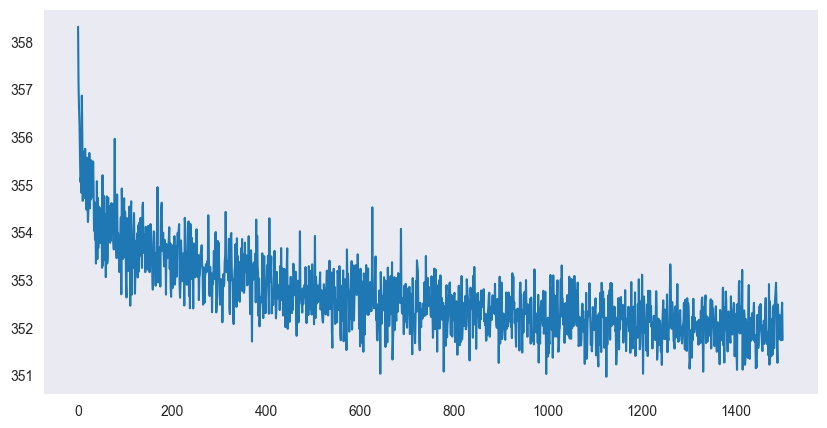

In [2]:
# Training function
def train(model, optimizer, dataloader, epochs=15):
    losses = []
    for epoch in trange(epochs, desc="Epochs"):
        for images, _ in dataloader:
            # Ensure images are float and on the proper device
            x_in = images.to(device)  # shape: (batch, 512)
            optimizer.zero_grad()
            x_out, z_mu, z_logvar = model(x_in)
            loss = criterion(x_out, x_in, z_mu, z_logvar)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
    return losses


train_losses = train(model, optimizer, trainloader)
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.show()
pass

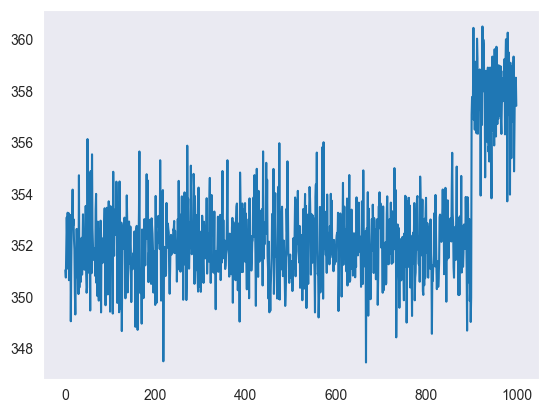

In [3]:
# Testing function (make sure to convert to float)
def test(model, dataloader):
    loss = []
    for images, _ in dataloader:
        x_in = images.to(device).float()
        x_out, z_mu, z_logvar = model(x_in)
        loss.append(criterion(x_out, x_in, z_mu, z_logvar).cpu().detach().numpy())
    return loss


test_loss = test(model, testloader)
plt.plot(test_loss)
pass